### TokaMaker Example: Equilibrium reconstruction in DIII-D Using Real Data {#doc_tMaker_DIIID_ex4}
==========
In this example we show how to perform an equilibrium reconstruction in DIII-D using real data from a gEQDSK file, a k-file and a MHDIn.dat file.

**Warning:** The reconstruction functionality in TokaMaker is still a work in progress, as the PSI-Tri capabilities are activated and tested. Please use with care.

In [1]:
import os
import sys
import json
import random
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain
from OpenFUSIONToolkit.TokaMaker.reconstruction import reconstruction
from OpenFUSIONToolkit.TokaMaker.util import read_eqdsk, read_mhdin, read_kfile

## Initialize TokaMaker object
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using two threads and a \ref OpenFUSIONToolkit.TokaMaker.TokaMaker "TokaMaker" instance to use for equilibrium calculations. Note at present only a single `TokaMaker` instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          18a434c
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/qz/wcp9q1mj0c5fsyjtbt99bvhh0000gn/T/oft_23538/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



## Load Info from gEQDSK File and MHDIn.Dat


In [4]:
shot_tag = '183593.04500'
# shot_tag = '174864.02400'
# shot_tag = '194414.05250'
eqdsk = read_eqdsk('DIIID_files/g'+shot_tag)

load_profs = False
use_SOL = False

e_coil_names = ['ECOILA','ECOILB','E567UP','E567DN','E89DN','E89UP']
f_coil_names = ['F1A', 'F2A', 'F3A', 'F4A', 'F5A', 'F6A', 'F7A', 'F8A', 'F9A', 'F1B', 'F2B', 'F3B', 'F4B', 'F5B', 'F6B', 'F7B', 'F8B', 'F9B']

machine_dict = read_mhdin('DIIID_files/mhdin.dat', e_coil_names, f_coil_names)

## Build Mesh in TokaMaker
Now we build and setup a mesh using DIII-D geometry from a given JSON file and MHDIn.dat. Then, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0. These values come from the gEQDSK file.

In [5]:
plasma_dx = 0.04
coil_dx = 0.03
vv_dx = 0.04
vac_dx = 0.10

with open('DIIID_files/DIIID_geom.json','r') as fid:
    DIIID_geom = json.load(fid)

# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')                     # Define the bounding region
gs_mesh.define_region('plasma',plasma_dx,'plasma')                 # Define the plasma region and resolution
gs_mesh.define_region('vacuum',vv_dx,'vacuum',allow_xpoints=True)  # Define the vacuum inside the VV
# Define regions for VV
for i, vv_segment in enumerate(DIIID_geom["vv"]):
    gs_mesh.define_region('vv{0}'.format(i),vv_dx,'conductor',eta=vv_segment[1])

# Define geometry
gs_mesh.add_polygon(DIIID_geom['limiter'],'plasma',parent_name='vacuum')  # Define the shape of the limiter
gs_mesh.add_enclosed([1.75,1.25],'vacuum')
# Define regions for VV
for i, vv_segment in enumerate(DIIID_geom["vv"]):
    gs_mesh.add_polygon(vv_segment[0],'vv{0}'.format(i),parent_name='air')

### Load E and F Coils from MHDIn.Dat

In [6]:
# Define F coils
for key, coil in DIIID_geom["coils"].items():
    if key.startswith('ECOIL'):
        continue
    gs_mesh.define_region(key,coil_dx,'coil',nTurns=machine_dict['FCOIL'][key][4])
    gs_mesh.add_polygon(coil["pts"],key,parent_name='air')

# Define E Coils
for coil_set_name, coil_set in machine_dict['ECOIL'].items():
    i = 0
    for coil in coil_set:
        coil_name = "{}_{}".format(coil_set_name, i)
        i = i + 1
        r, z, w, h = coil
        gs_mesh.define_region(coil_name,coil_dx,'coil',coil_set=coil_set_name,nTurns=1) # Check nTurns
        gs_mesh.add_rectangle(r, z, w, h, coil_name, parent_name='air')


### Plot Topology

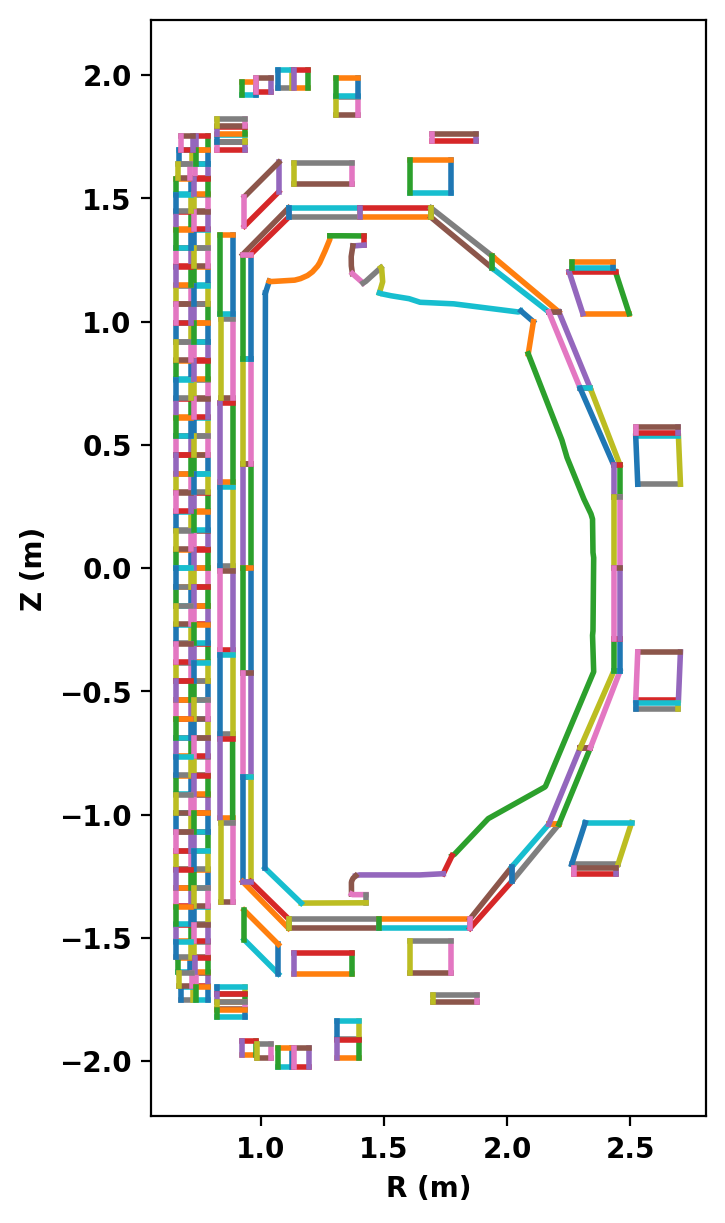

In [7]:
fig, ax = plt.subplots(1,1,figsize=(4,6),constrained_layout=True)
gs_mesh.plot_topology(fig,ax)

plt.show()

### Setup Mesh

In [8]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 = eqdsk['rcentr']*eqdsk['bcentr'])

Assembling regions:
  # of unique points    = 1836
  # of unique segments  = 657
Generating mesh:
  # of points  = 12951
  # of cells   = 25740
  # of regions = 167

**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.574E+01
    # of points  =   12951
    # of edges   =   38690
    # of cells   =   25740
    # of boundary points =     160
    # of boundary edges  =     160
    # of boundary cells  =     160
  Resolution statistics:
    hmin =  8.702E-04
    hrms =  4.001E-02
    hmax =  1.520E-01
  Surface grounded at vertex    1813


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    2.3010000000000001E-003


At line 5532 of file /Users/johnl/Desktop/OpenFUSIONToolkit-SOL-Currents/src/physics/grad_shaf.F90
Fortran runtime warning: An array temporary was created for argument 'b' of procedure 'mat_add_values'
At line 5536 of file /Users/johnl/Desktop/OpenFUSIONToolkit-SOL-Currents/src/physics/grad_shaf.F90
Fortran runtime warning: An array temporary was created for argument 'b' of procedure 'mat_add_values'


## Update GS Settings

In [9]:
# Update maximum number of solver iterations
mygs.settings.maxits=1000
# mygs.settings.sol_currents = True
mygs.update_settings()

## Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds()". In this case we just the simple and approximate bi-directional limit of 5 MA in each coil.

Bounds are specified using a dictionary of 2 element lists, containing the minimum and maximum bound, where the dictionary key corresponds to the coil names, which are available in \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.coil_sets "mygs.coil_sets"

In [10]:
coil_bounds = {key: [-5.E6, 5.E6] for key in mygs.coil_sets}
mygs.set_coil_bounds(coil_bounds)

## Define vertical stability coils

In [11]:
vsc_signs = {key: 0 for key in mygs.coil_sets}
vsc_signs['F9A'] = 1.0
vsc_signs['F9B'] = -1.0
mygs.set_coil_vsc(vsc_signs)

## Perform Reconstruction

### Create Reconstruction Object

In [12]:
myrecon = reconstruction(mygs)

### Define Helper Functions to Read Sensor Locations
For this example we load data representing flux loops and Mirnov sensor locations and orientations in DIII-D from several text files. The signals in these sensors will be used to constrain the reconstruction along with coil currents and global plasma quantities (eg. $I_p$). First we define two helper functions to read Flux Loop and Mirnov sensor configurations.

In [13]:
def read_points_flux(file_path,  sensor_names = None):
    points = OrderedDict()
    with open(file_path, 'r') as file:
        for line in file:
            if sensor_names is not None:
                name, r, z = line.strip().split()  # Split and ignore the first field (name)
                if name in sensor_names:
                    points[name] = [float(r),float(z)]
            else:
                name, r, z = line.strip().split()  # Split and ignore the first field (name)
                points[name] = [float(r),float(z)]
    return points
    
def read_points_mag(file_path, sensor_names = None):
    points = OrderedDict()
    with open(file_path, 'r') as file:
        for line in file:
            if sensor_names is not None: 
                name, r, z, pol, orient, _, _, _ = line.strip().split()  # Split and ignore the first field (name)
                if name in sensor_names:
                    points[name] = [float(r), float(z), float(orient)]
            else: 
                name, r, z, pol, orient, _, _, _ = line.strip().split()  # Split and ignore the first field (name)
                points[name] = [float(r), float(z), float(orient)]  # Convert r and z to floats and append
    return points

### Load Sensor Locations From Files

In [14]:
magSensors322 = read_points_mag('DIIID_files/3222magsensorloc.txt')
fluxLoops_onf = read_points_flux('DIIID_files/fcoil_fluxloops.txt')
fluxLoops_vv = read_points_flux('DIIID_files/vv_fluxloops.txt')

### Plot probe locations

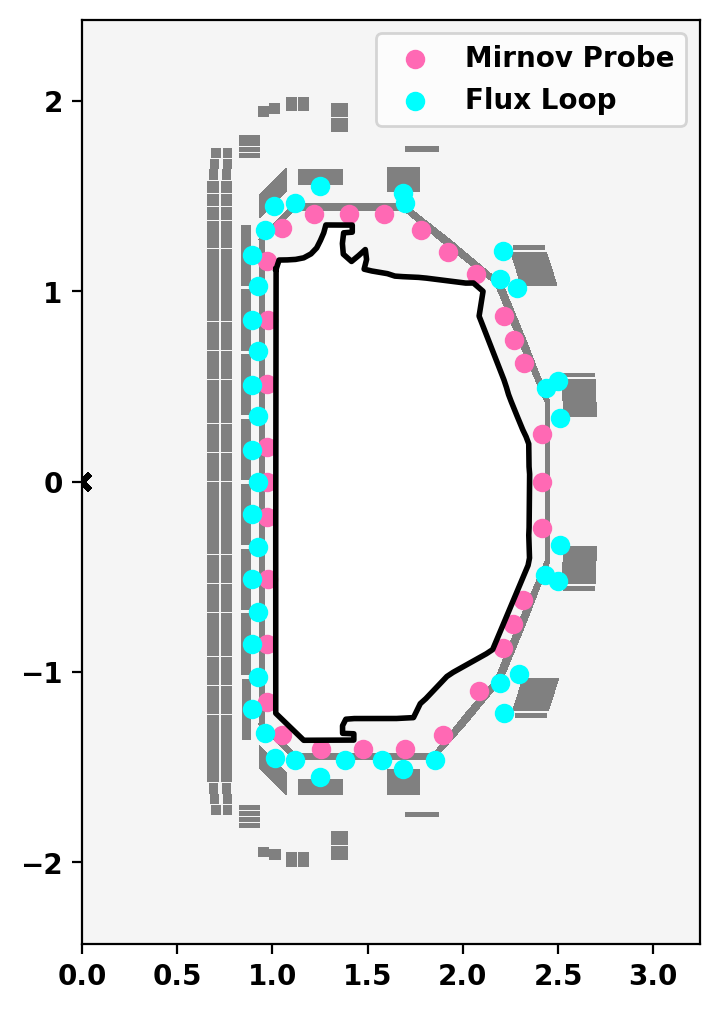

In [15]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color='k')
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)

def plot_sensors(sensors, label, color):
    r_coords = [s[0] for _,s in sensors.items()]
    z_coords = [s[1] for _,s in sensors.items()]
    ax.scatter(x=r_coords, y=z_coords, label=label, color=color)

plot_sensors(magSensors322, label="Mirnov Probe", color='hotpink')
plot_sensors({**fluxLoops_vv, **fluxLoops_onf}, label="Flux Loop", color='cyan')

ax.legend()
plt.show()

### Load Shot Data from DIII-D
Here we load data from a DIII-D k file representing a shot at a given point in time.

In [16]:
probes_dict, loops_dict, e_coil_dict, f_coil_dict = read_kfile('DIIID_files/k'+shot_tag, e_coil_names, f_coil_names, machine_dict)

### Read Data From DIII-D to Mirnov Probes

In [17]:
def convert_Mirnov_coordinates(sensor, angle):
    R, z, _ = sensor
    position = np.array([R, z])

    angle_rads = angle * np.pi / 180
    orientation = np.array([np.cos(angle_rads), 0, np.sin(angle_rads)])
    return position, orientation

B_vals = [probes_dict[key][0] for key in magSensors322 if key in probes_dict]
B_mean = np.mean(np.positive(B_vals))
mirnov_names = []

for key, mag in magSensors322.items():
    mirnov_names.append(key)
    position, orientation = convert_Mirnov_coordinates(mag, machine_dict['AMP2'][key])
    B_meas, _ = probes_dict[key]
    myrecon.add_Mirnov(position, orientation, B_meas, err=0.1*max(B_mean, abs(B_meas)))


### Read Data From Equilibrium to Flux Loops

In [18]:
flux_locs = []
flux_vals = []

psi_vals_1 = [loops_dict[key][0] for key in fluxLoops_onf if key in loops_dict]
psi_mean_1 = np.mean(np.positive(psi_vals_1))
psi_vals_2 = [loops_dict[key][0] for key in fluxLoops_vv if key in loops_dict]
psi_mean_2 = np.mean(np.positive(psi_vals_2))

flux_names = []

for key, fl in fluxLoops_onf.items():
    if key not in loops_dict:
        continue
    flux_names.append(key)
    B_tmp, _ = loops_dict[key]
    flux_locs.append(fl)
    flux_vals.append(B_tmp)
    psi_val = B_tmp*2.0*np.pi
    myrecon.add_flux_loop(fl, psi_val, err=0.1*(max(psi_mean_1, abs(psi_val))))

for key, fl in fluxLoops_vv.items():
    if key not in loops_dict:
        continue
    flux_names.append(key)
    B_tmp, _ = loops_dict[key]
    flux_locs.append(fl)
    flux_vals.append(B_tmp)
    psi_val = B_tmp*2.0*np.pi
    myrecon.add_flux_loop(fl, psi_val, err=0.1*(max(psi_mean_2, abs(psi_val))))

## Profiles

In [19]:
# Define SOL FF' Bump Function
f_0 = 1.0
f_c = 1.0
psi_sol = 1.0
psi_pf = 1.0
delta = 1.0

def bump(psi_n):
    return f_0 * (-1.0 * delta **2 / (psi_sol ** 2 - psi_n ** 2)) + f_c

In [20]:
if load_profs:
    ffprim = np.array(eqdsk['ffprim'])
    pprime = np.array(eqdsk['pprime'])
else:
    ffprim = np.array([1.0, 0.0])
    pprime = np.array([1.0, 0.0])

if use_SOL:
    interp_pts_f = np.r_[np.linspace(0.0, 1.5, 75), [100.0]]
    psi_ff = np.linspace(0.0, 1.0, len(ffprim))
    pts_sol = [1.0, 1.25, 1.5, 100.0]
    ff_sol = [0.0, -0.2, 0.0, 0.0]
    
    psi_ff = np.r_[psi_ff, pts_sol]
    ffprim = np.r_[ffprim, ff_sol]
    ff_interp = np.interp(interp_pts_f, psi_ff, ffprim)
    ffp_prof={'type': 'linterp', 'y': ff_interp, 'x': interp_pts_f}
    
    interp_pts_p = np.linspace(0.0, 1.0, 50)
    psi_p = np.linspace(0.0, 1.0, len(pprime))
    p_interp = np.interp(interp_pts_p, psi_p, pprime)
    pp_prof={'type': 'linterp', 'y': p_interp, 'x': interp_pts_p}
else:
    interp_pts = np.linspace(0.0, 1.0, 50)
    psi_ff = np.linspace(0.0, 1.0, len(ffprim))
    ff_interp = np.interp(interp_pts, psi_ff, ffprim)
    ffp_prof={'type': 'linterp', 'y': ff_interp, 'x': interp_pts}

    psi_pp = np.linspace(0.0, 1.0, len(pprime))
    pp_interp = np.interp(interp_pts, psi_pp, pprime)
    pp_prof={'type': 'linterp', 'y': pp_interp, 'x': interp_pts}

mygs.set_profiles(ffp_prof=ffp_prof, pp_prof=pp_prof, f_SOL=use_SOL)

## Compute starting equilibrium

In [21]:
##### Add plasma current and flux loop constraints
Ip_target=abs(eqdsk['ip'])
P0_target=eqdsk['pres'][0]
mygs.set_targets(Ip=Ip_target, pax=P0_target)

mygs.set_flux(np.array(flux_locs), np.array(flux_vals))
# isoflux_pts = eqdsk['rzout'].copy()
# mygs.set_isoflux(isoflux_pts)

target_currents = {}

for key, value in e_coil_dict.items():
    target_currents[key] = value[0]

for key, value in f_coil_dict.items():
    target_currents[key] = value[0] / machine_dict['FCOIL'][key][4]


# Set coil regularization to weakly track measured coil currents
regularization_terms = []
for key in e_coil_dict:
    regularization_terms.append(mygs.coil_reg_term({key: 1.0},
                                                   target=target_currents[key],
                                                   weight=1.0E1))
for key in f_coil_dict:
    weight = 1.0
    if key.startswith('F5'):
        weight = 1.0E2
    regularization_terms.append(mygs.coil_reg_term({key: 1.0},
                                                   target=target_currents[key],
                                                   weight=1.0E2))

# Set zero target current and small weight on virtual VSC to allow up-down adjustment
regularization_terms.append(mygs.coil_reg_term({'#VSC': 1.0},target=0.0,weight=1.E-2))

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(reg_terms=regularization_terms)

# Initial equilibrium with very rough guess
R0 = eqdsk['rcentr']
Z0 = 0.0
a = 0.6
kappa = 1.13
delta = .1

err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)

# Compute initial equilibrium
mygs.update_settings()
mygs.solve()

At line 2065 of file /Users/johnl/Desktop/OpenFUSIONToolkit-SOL-Currents/src/physics/grad_shaf.F90
Fortran runtime warning: An array temporary was created


Starting non-linear GS solver
     1 -4.8369E-01  5.9964E-01  2.4793E-03  1.6880E+00 -2.1416E-02 -2.9333E+00
     2  1.7994E+00  2.6052E-01  1.3281E-03  1.6767E+00 -1.9487E-02 -1.4111E+01
     3  2.2766E+00  2.2338E-01  8.5414E-04  1.6678E+00 -1.7719E-02 -1.9195E+01
     4  2.5169E+00  2.1098E-01  5.4929E-04  1.6616E+00 -1.6316E-02 -2.2548E+01
     5  2.6578E+00  2.0556E-01  3.5904E-04  1.6570E+00 -1.5098E-02 -2.5097E+01
     6  2.7454E+00  2.0286E-01  2.4327E-04  1.6536E+00 -1.4007E-02 -2.7196E+01
     7  2.8018E+00  2.0144E-01  1.7276E-04  1.6510E+00 -1.3020E-02 -2.9021E+01
     8  2.8395E+00  2.0067E-01  1.2856E-04  1.6489E+00 -1.2074E-02 -3.0640E+01
     9  2.8655E+00  2.0025E-01  9.9475E-05  1.6472E+00 -1.1190E-02 -3.2119E+01
    10  2.8841E+00  2.0002E-01  7.9362E-05  1.6458E+00 -1.0367E-02 -3.3480E+01
    11  2.8977E+00  1.9989E-01  6.4850E-05  1.6447E+00 -9.5971E-03 -3.4743E+01
    12  2.9080E+00  1.9982E-01  5.4033E-05  1.6438E+00 -8.8760E-03 -3.5920E+01
    13  2.9159E+00  1.

## Plot starting equilibrium

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    4.9546E+05
  Current Centroid [m]    =    1.587  0.003
  Magnetic Axis [m]       =    1.640  0.002
  Elongation              =    1.155 (U:  1.156, L:  1.153)
  Triangularity           =    0.059 (U:  0.057, L:  0.062)
  Plasma Volume [m^3]     =   11.565
  q_0, q_95               =   -1.297 -3.517
  Peak Pressure [Pa]      =    9.8029E+03
  Stored Energy [J]       =    4.5831E+04
  <Beta_pol> [%]          =   25.2991
  Diamagnetic flux [Wb]   =   -8.1471E-03
  Toroidal flux [Wb]      =   -1.6473E+00
  l_i                     =    0.9800


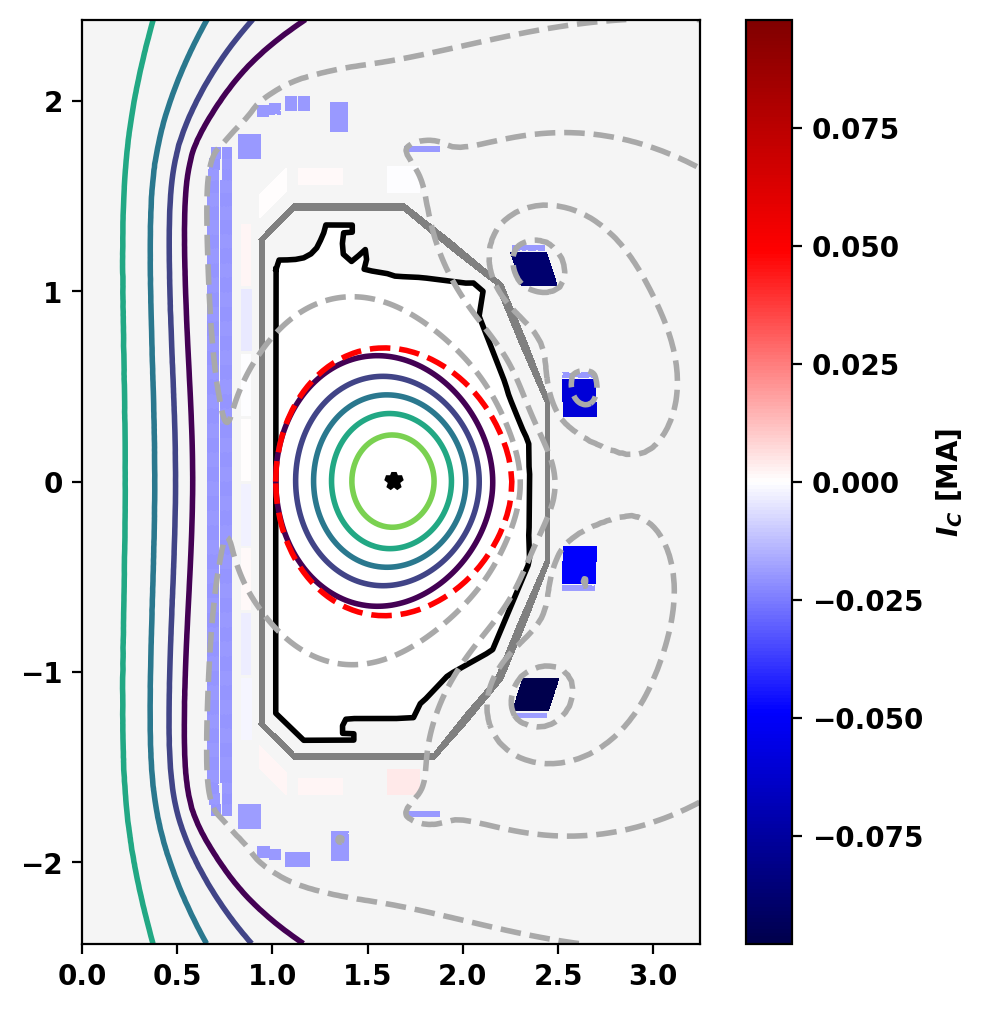

In [22]:
psi_eq = mygs.get_psi()
mygs.print_info()

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,normalized=True,plasma_nlevels=6,vacuum_nlevels=5)
# mygs.plot_psi(fig,ax,psi_eq,plasma_levels=[1.0,],plasma_color='red',vacuum_nlevels=0,plasma_linestyles='dashed')
_ = ax.plot(eqdsk['rzout'][:,0], eqdsk['rzout'][:,1],'r--')
# plot_sensors({**fluxLoops_vv, **fluxLoops_onf}, label="Flux Loop", color='cyan')

plt.show()

In [23]:
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key, current in coil_currents.items():
    if key not in target_currents:
        continue
    current_adj = current
    # if key.startswith('F'):
    #     current_adj = current/machine_dict['FCOIL'][key][4]
    measured_currt = target_currents[key]
    pct_diff = 100.0 * (current_adj-measured_currt)/measured_currt
    print('  {0:10} {1:11.3F} {2:11.3F} {3:10.2F}%'.format(key+":", current_adj/1.E3, measured_currt/1.E3, pct_diff))

Coil Currents [kA]:
  F1A:             0.007       0.022     -66.77%
  F2A:            -0.005       0.007    -168.37%
  F3A:            -0.070      -0.063      10.93%
  F4A:             0.028       0.033     -15.12%
  F5A:             0.000       0.006     -97.86%
  F6A:            -1.075      -1.161      -7.40%
  F7A:            -1.612      -1.651      -2.36%
  F8A:             0.023       0.031     -23.42%
  F9A:            -0.004       0.053    -107.24%
  F1B:            -0.043      -0.025      70.51%
  F2B:             0.021       0.033     -34.59%
  F3B:            -0.059      -0.056       5.28%
  F4B:            -0.035      -0.035       0.71%
  F5B:             0.027       0.028      -5.23%
  F6B:            -0.896      -0.989      -9.41%
  F7B:            -1.780      -1.833      -2.92%
  F8B:             0.028       0.031     -12.13%
  F9B:             0.076       0.025     205.31%
  ECOILA:        -20.018     -19.601       2.13%
  ECOILB:        -19.812     -19.395       2.15%


## Plot Measured vs. Computed SE Values

### Plot SE Currents

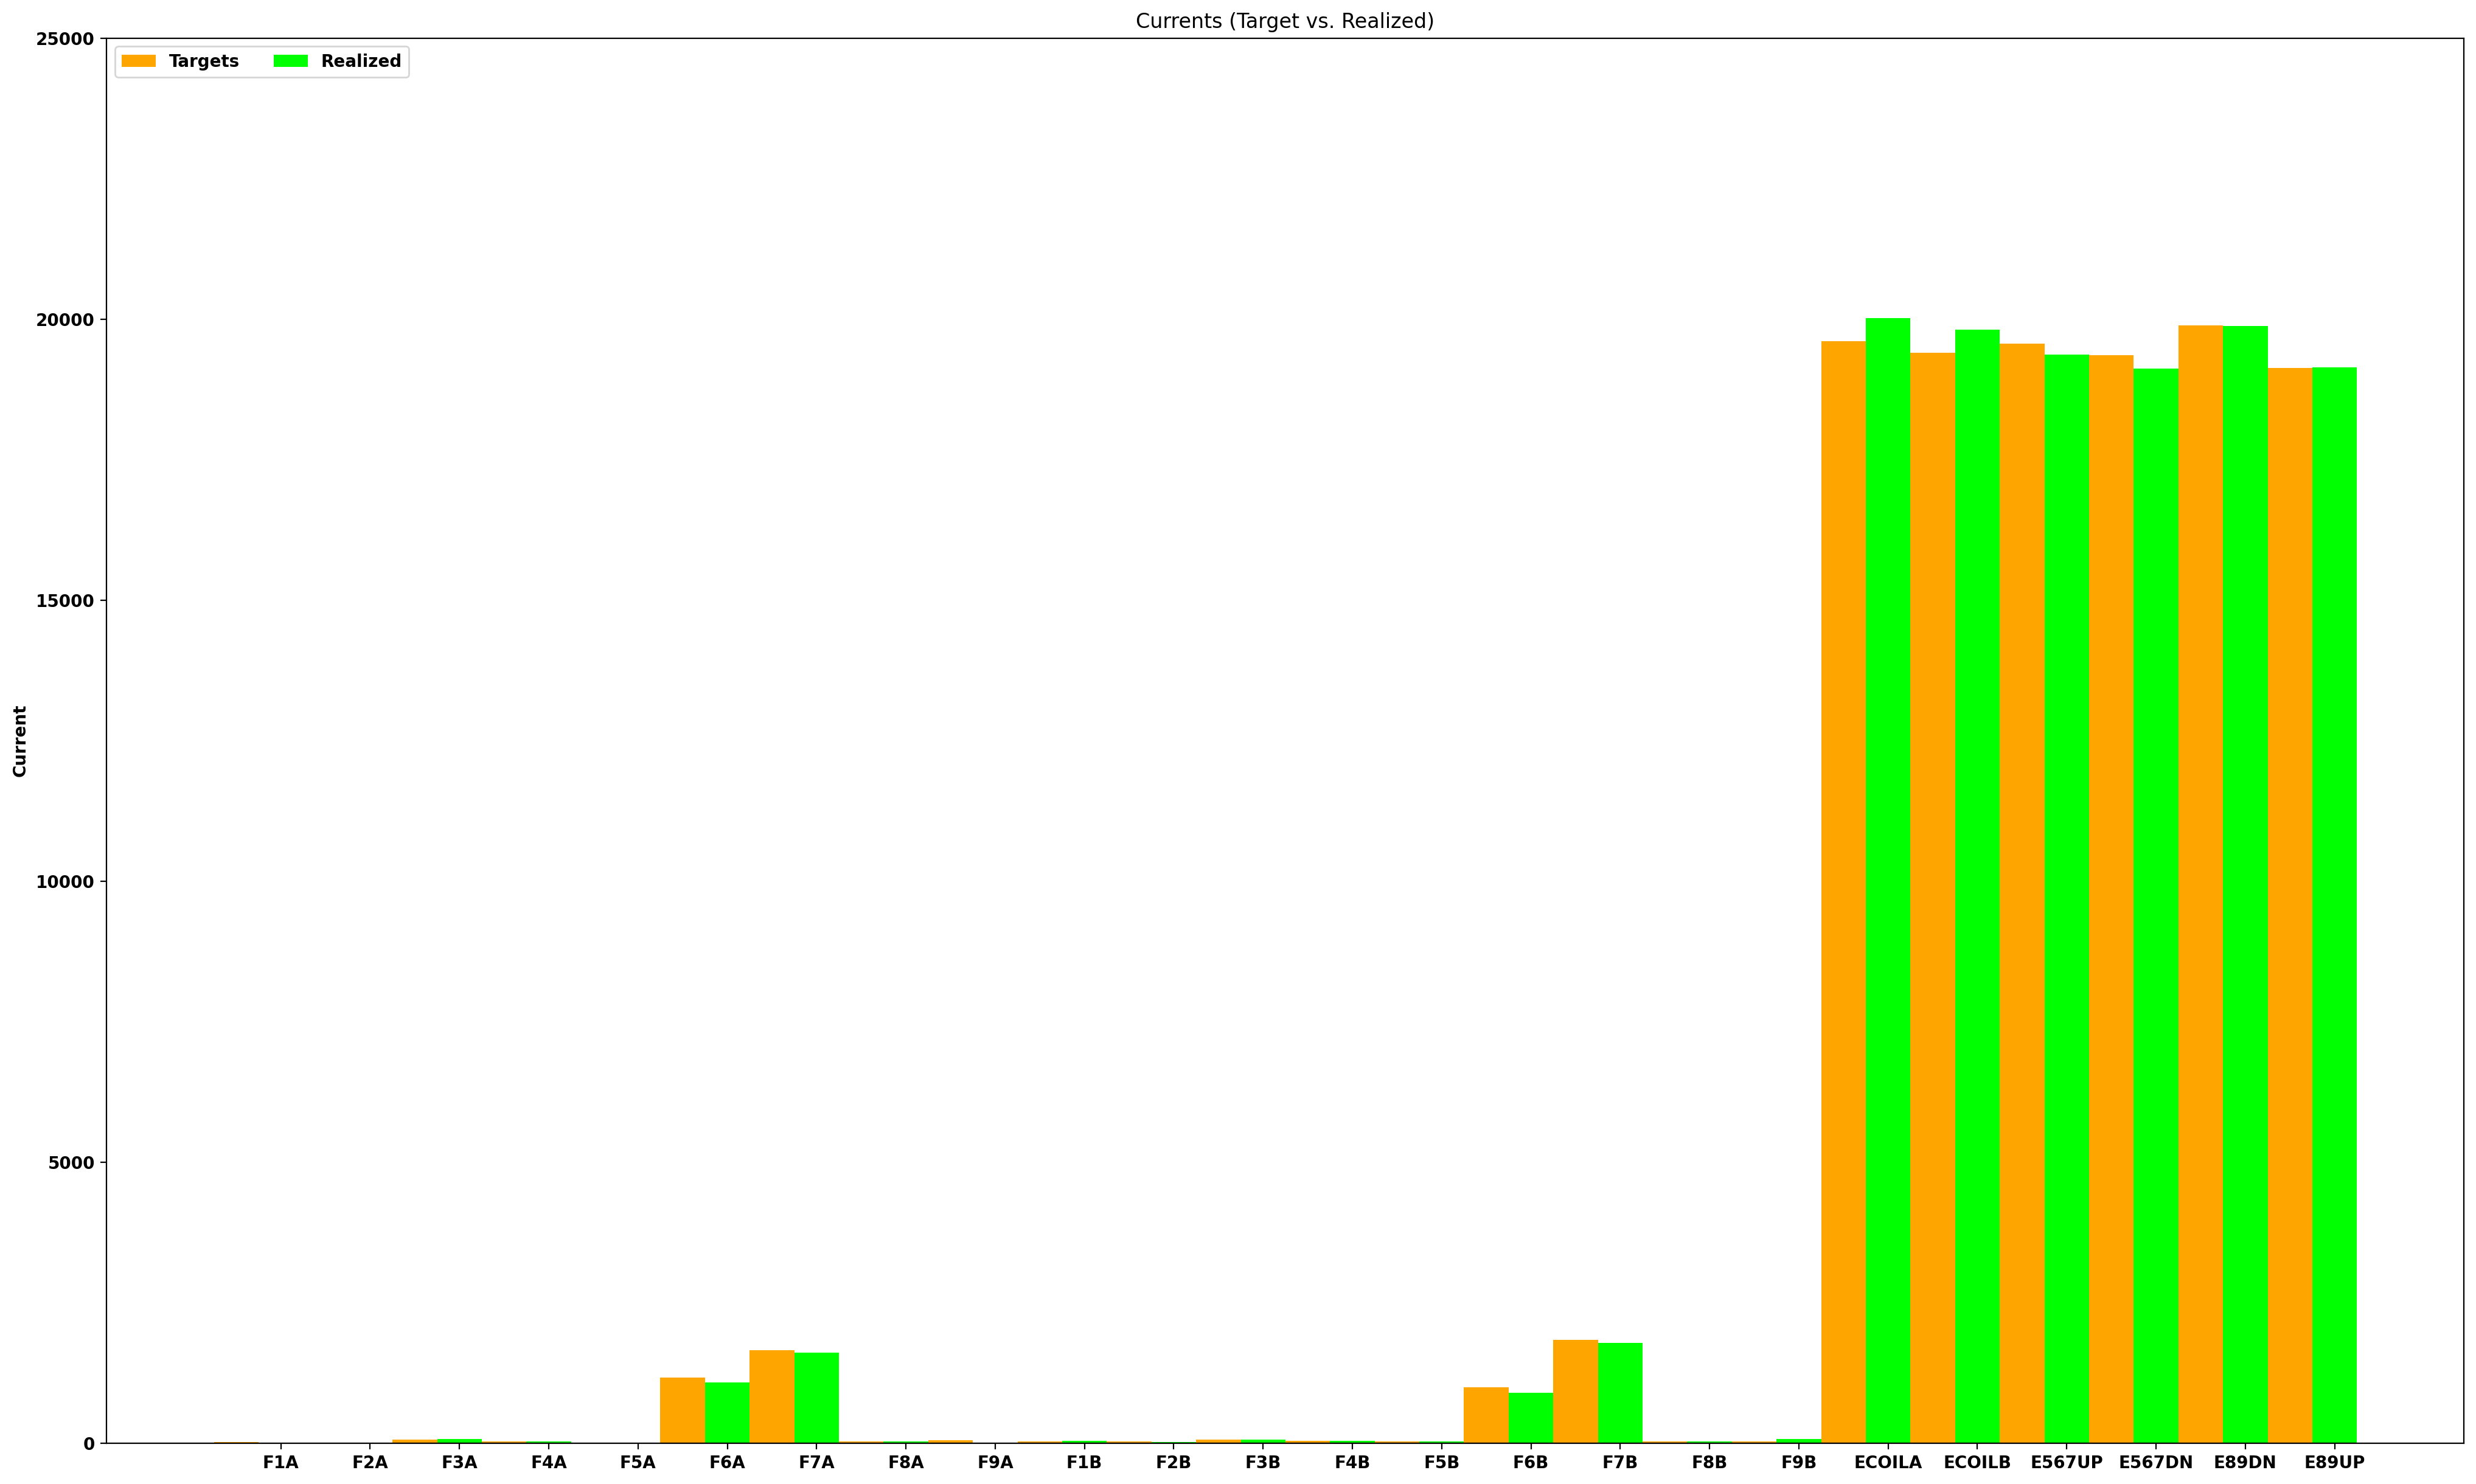

In [24]:
plot_colors = {'Targets': 'orange', 'Realized': 'lime'}

def plot_currents():
    coil_currents, _ = mygs.get_coil_currents()
    coil_names = [key for key in coil_currents if key in target_currents]
    coil_info = {'Targets': [abs(target_currents[key]) for key in coil_names if key in target_currents],
                 'Realized': [abs(coil_currents[key]) for key in coil_names if key in target_currents]}
    
    x = np.arange(len(coil_names))  # the label locations
    width = 0.5  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(figsize=(25, 15))
    
    for attribute, measurement in coil_info.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, color=plot_colors[attribute])
    #     ax.bar_label(rects, padding=3)
        multiplier += 1
    
    ax.set_ylabel('Current')
    ax.set_title('Currents (Target vs. Realized)')
    ax.set_xticks(x + width, coil_names)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 2.5E4)
    
    plt.show()

plot_currents()

### Plot SE Sensors

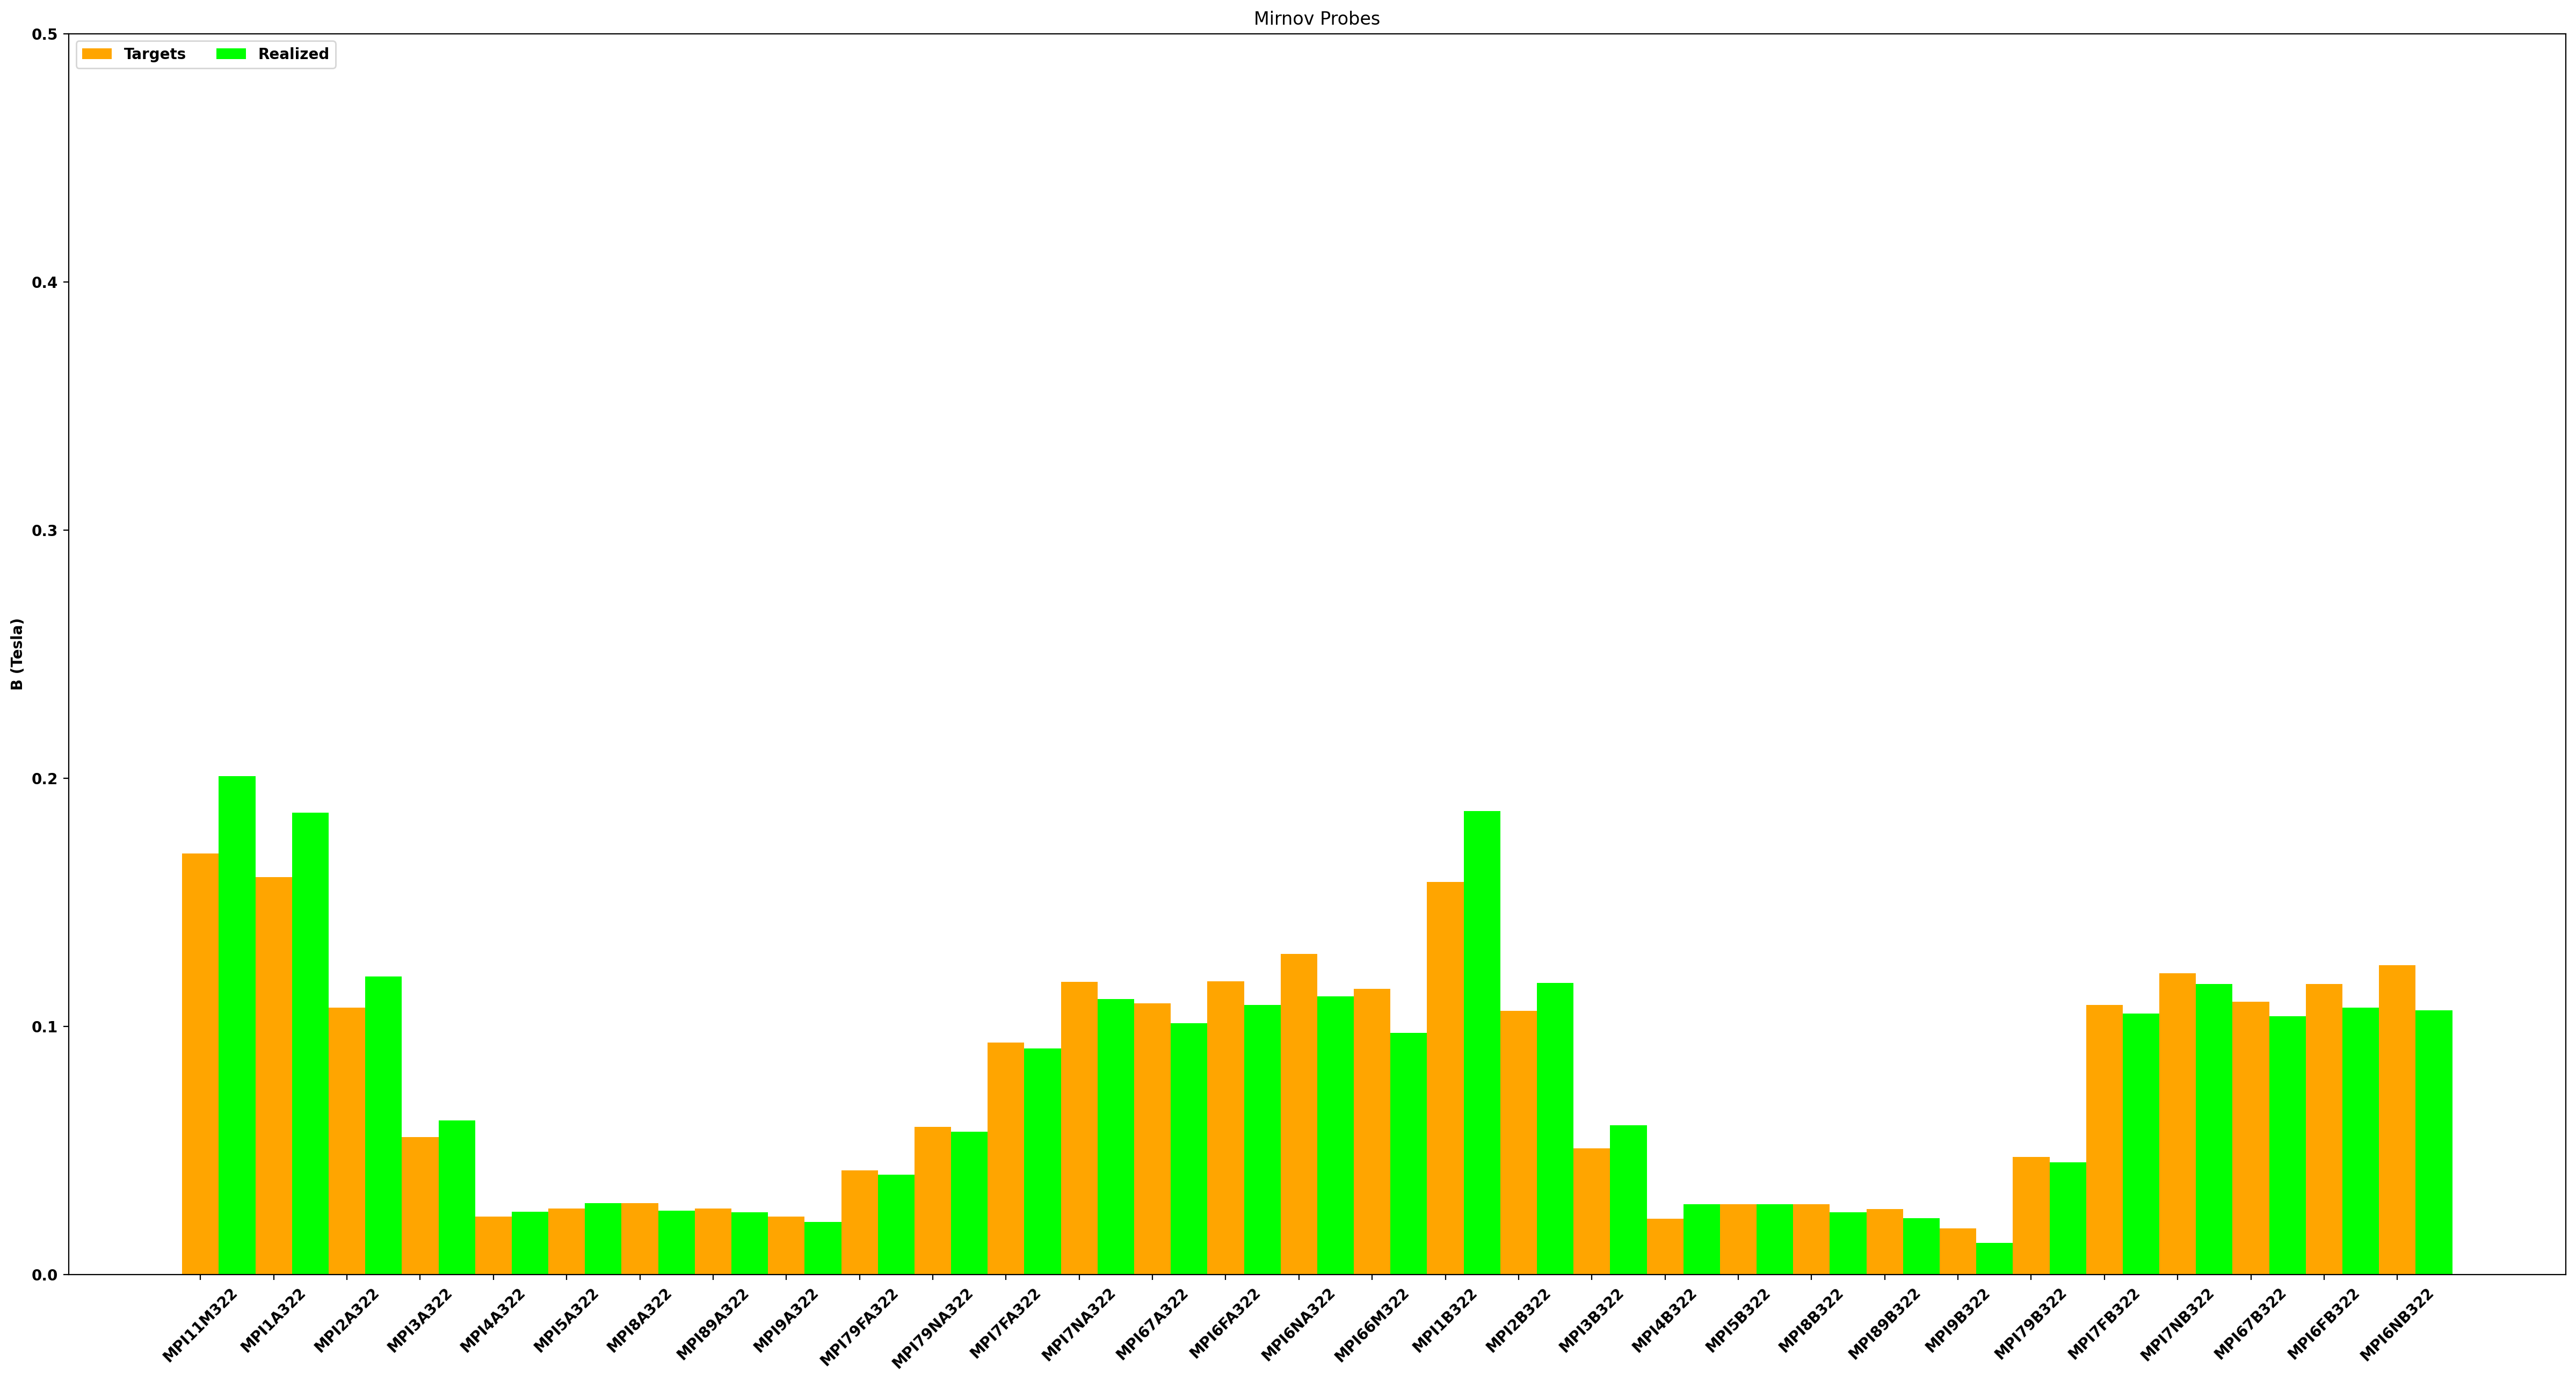

In [25]:
def plot_mirnov():
    mirnov_vals = []
    B_eval = mygs.get_field_eval('B')
    for key in mirnov_names:
        coords = magSensors322[key]
        position, orientation = convert_Mirnov_coordinates(coords, machine_dict['AMP2'][key])
        B_field = B_eval.eval(position)
        mirnov_vals.append(np.dot(B_field, orientation))
    
    mirnov_targets = [probes_dict[key][0] for key in mirnov_names]
    mirnov_info = {'Targets': mirnov_targets,
                 'Realized': mirnov_vals}
    
    x_m = np.arange(len(mirnov_names))  # the label locations
    width = 0.5  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(1, figsize=(30, 15))
    
    for attribute, measurement in mirnov_info.items():
        offset = width * multiplier
        rects_m = ax.bar(x_m + offset, measurement, width, label=attribute, color=plot_colors[attribute])
        multiplier += 1
    
    ax.set_ylabel('B (Tesla)')
    ax.set_title('Mirnov Probes')
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 0.5)
    ax.set_xticks(x_m, labels=mirnov_names, rotation=45)
    
    plt.show()

plot_mirnov()

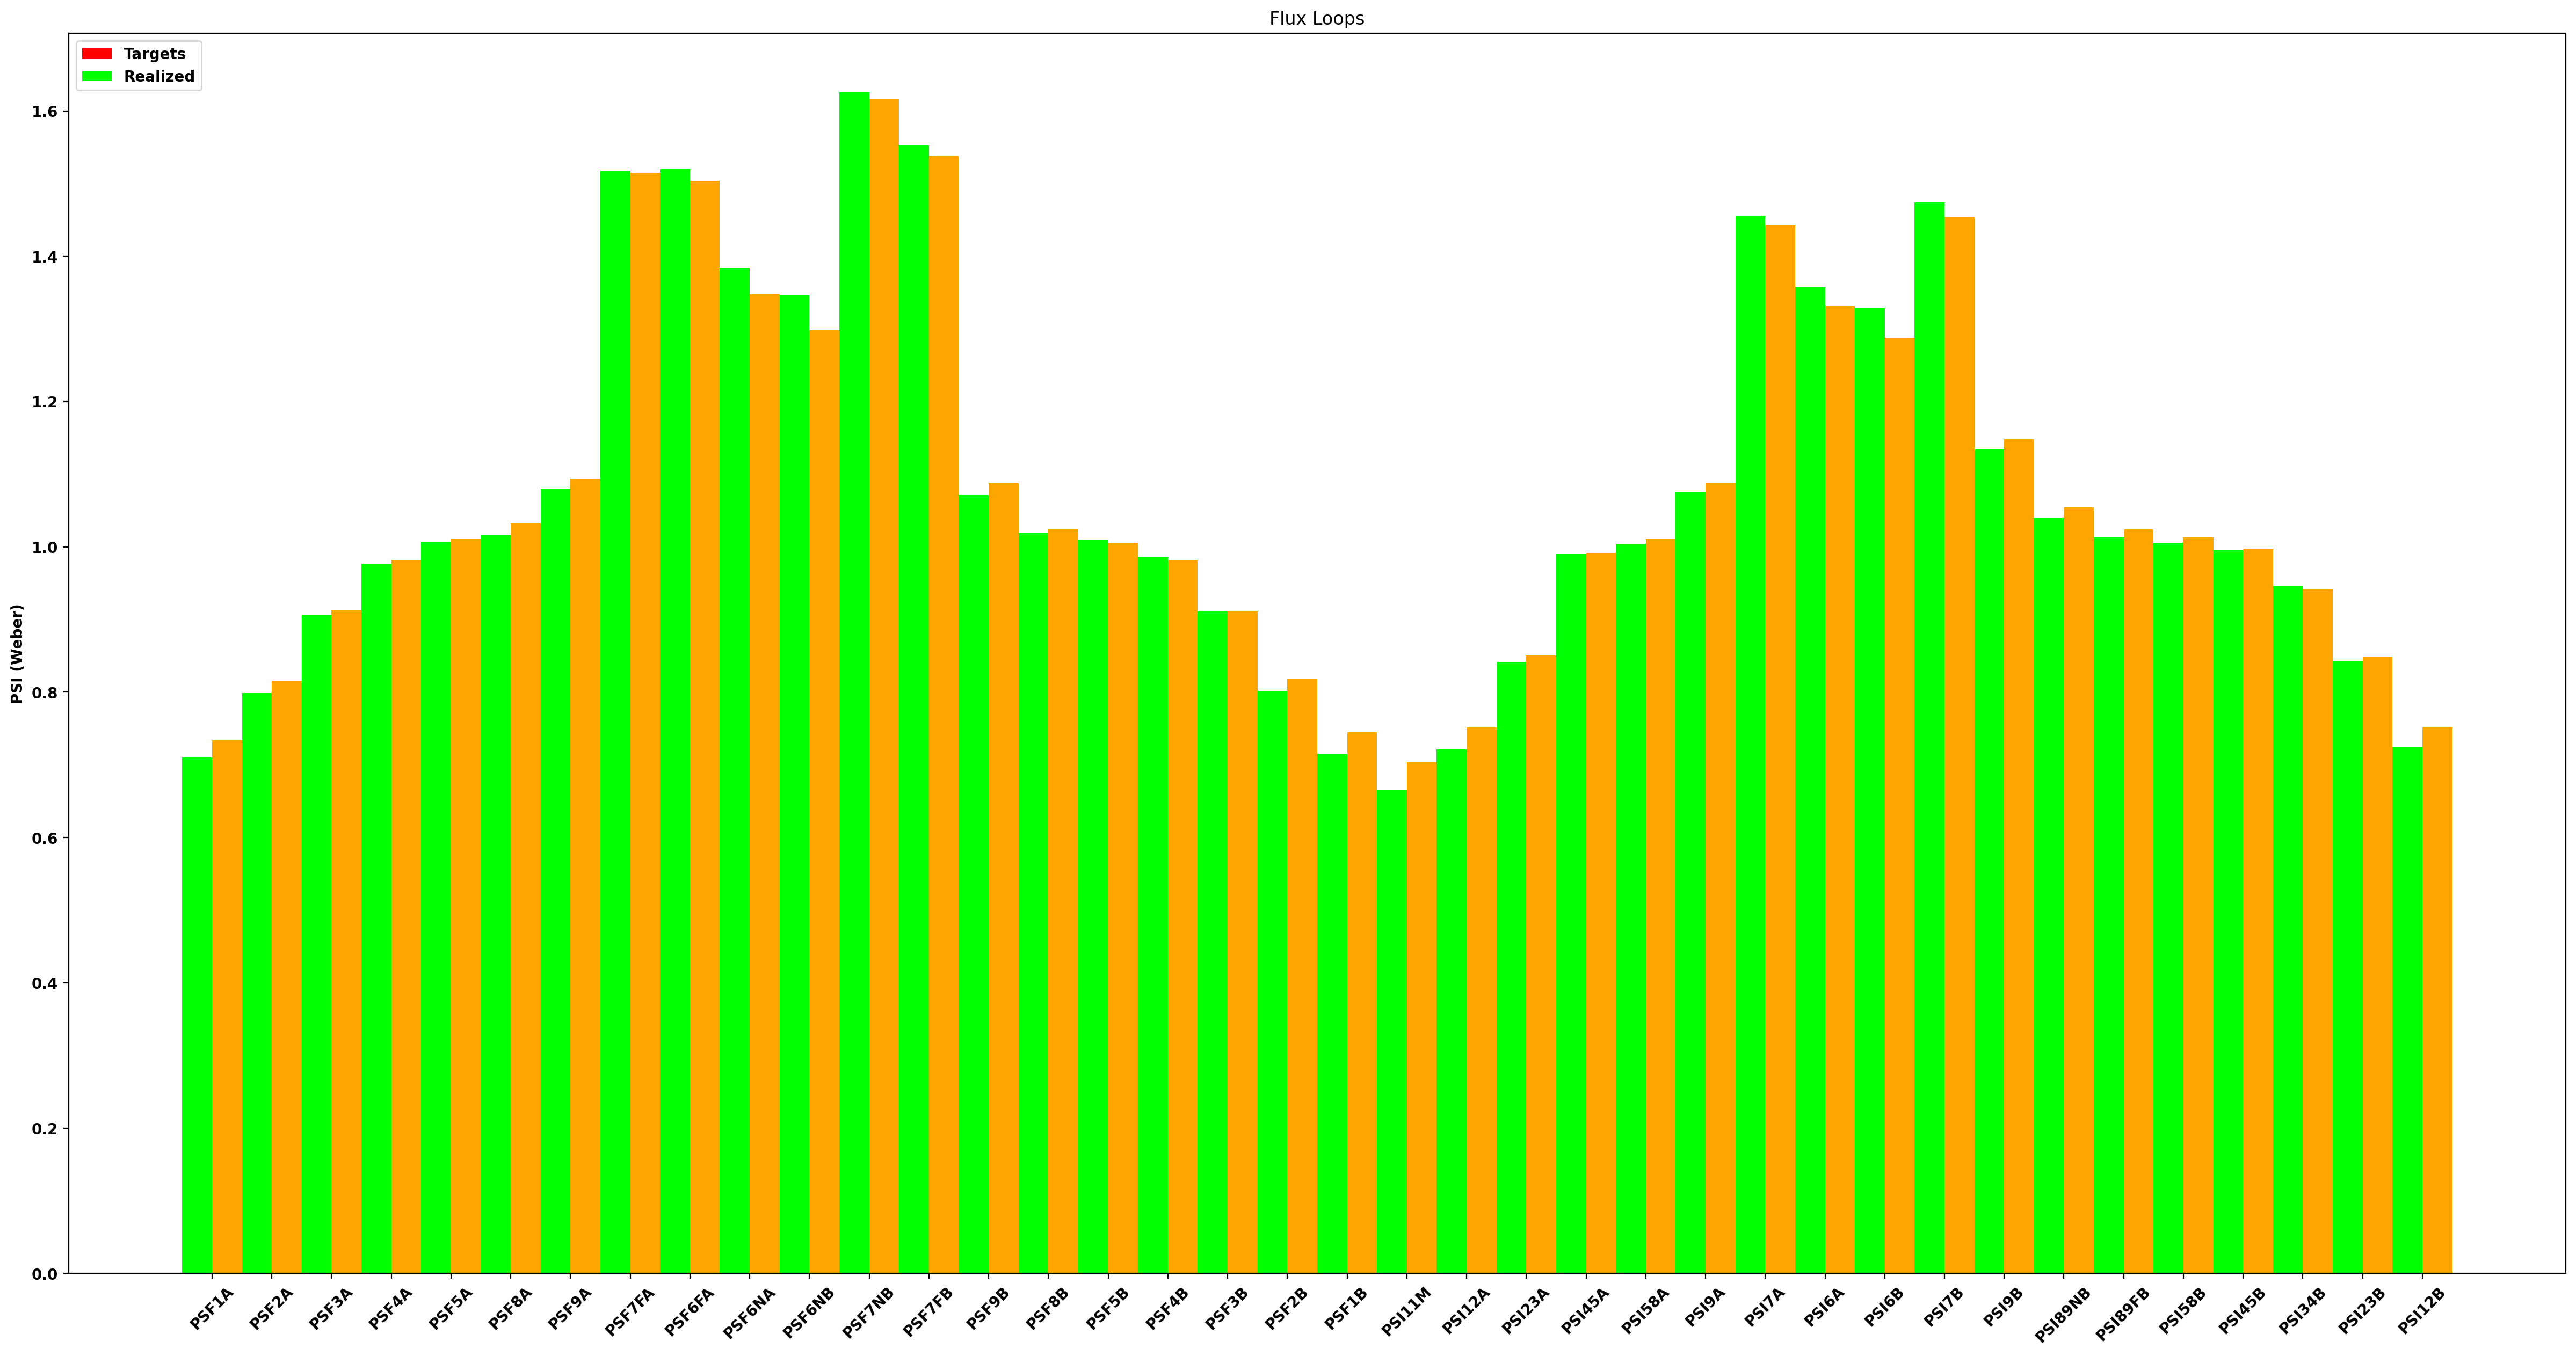

In [26]:
from matplotlib.patches import Patch

def plot_flux():
    flux_vals = []
    flux_dict = {**fluxLoops_onf, **fluxLoops_vv}
    psi_eval = mygs.get_field_eval('PSI')
    for key in flux_names:
        position = flux_dict[key]
        psi_value = psi_eval.eval(position) * 2 * np.pi
        flux_vals.append(psi_value)

    flux_targets = [2 * np.pi * loops_dict[key][0] if key in loops_dict else 0.0 for key in flux_names]
    flux_info = {'Targets': flux_targets,
                 'Realized': flux_vals}
    
    figs, ax = plt.subplots(1, figsize=(30, 15))
    
    x_f = np.arange(len(flux_names))  # the label locations
    width = 0.5  # the width of the bars
    multiplier = 0
    
    flux_targets_data = {flux_names[i]: flux_targets[i] for i in range(len(flux_names))}
    flux_vals_data = {flux_names[i]: flux_vals[i] for i in range(len(flux_names))}    
    
    for i in range(len(flux_names)):
        ax.bar(flux_names[i], height = -flux_targets[i], width=0.5, color=plot_colors['Targets'], align='edge')
        ax.bar(flux_names[i], height = -flux_vals[i], width=-0.5, color=plot_colors['Realized'], align='edge')
    
    legend_elements = [Patch(facecolor='red', label='Targets'), Patch(facecolor=plot_colors['Realized'], label='Realized')]
    ax.legend(handles=legend_elements,loc='upper left')
    
    ax.set_ylabel('PSI (Weber)')
    ax.set_title('Flux Loops')
    # ax.set_ylim(0, 1.5)
    ax.set_xticks(x_f, labels=flux_names, rotation=45)
    
    plt.show()

plot_flux()

### Perform Reconstruction

In [27]:
# Remove all shape constraints
mygs.set_isoflux(None)
mygs.set_flux(None,None)
mygs.set_saddles(None)

# Set initial position targets from current values
mygs.set_targets(R0=mygs.o_point[0],V0=mygs.o_point[1])

# Set Recon Plasma Current
myrecon.set_Ip(Ip_target, err=0.1*Ip_target)

# Set reconstruction settings
myrecon.settings.fitPnorm = False
myrecon.settings.fitR0 = True
myrecon.settings.fitV0 = True
myrecon.settings.fitCoils = True
myrecon.settings.pm = False

# Perform reconstructions
err_flag = myrecon.reconstruct()


*** Loading fit constraints ***

Starting Fit:
  # of free parameters   =   27
  # of constraints       =   94

Function evaluation    1
  Alam              =  2.950E+00
  P_scale           =  1.998E-01
  R0_target         =  1.640E+00
  V0_target         =  2.428E-03
  Coil currents [%]  =  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00 -0.000E+00  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00
  Maximum Rel Error =  3.224E-01
  Maximum Abs Error =  1.003E+00
  Total Weighted Error   =  5.133E+00
  RMS Weighted Error     =  5.294E-01

Function evaluation    2
  Alam              =  2.950E+00
  P_scale           =  1.998E-01
  R0_target         =  1.640E+00
  V0_target         =  2.428E-03
  Coil currents [%]  =  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00 -0.000E+00  0.000E+00

### Print equilibrium information and coil currents
As above we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents()" to display information on the final equilibrium.

In [28]:
mygs.print_info()

print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key, current in coil_currents.items():
    if key not in target_currents:
        continue
    measured_currt = target_currents[key]
    pct_diff = 100.0 * (current-measured_currt)/measured_currt
    print('  {0:10} {1:11.3F} {2:11.3F} {3:10.2F}%'.format(key+":", current/1.E3, measured_currt/1.E3, pct_diff))

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    4.8297E+05
  Current Centroid [m]    =    1.665  0.003
  Magnetic Axis [m]       =    1.723  0.002
  Elongation              =    1.147 (U:  1.151, L:  1.144)
  Triangularity           =    0.084 (U:  0.090, L:  0.078)
  Plasma Volume [m^3]     =   13.855
  q_0, q_95               =   -1.372 -4.146
  Peak Pressure [Pa]      =    1.7718E+04
  Stored Energy [J]       =    9.8444E+04
  <Beta_pol> [%]          =   55.8115
  Diamagnetic flux [Wb]   =   -4.8782E-03
  Toroidal flux [Wb]      =   -1.8734E+00
  l_i                     =    1.0037

Coil Currents [kA]:
  F1A:             0.007       0.022     -66.77%
  F2A:            -0.005       0.007    -168.37%
  F3A:            -0.069      -0.063      10.90%
  F4A:             0.028       0.033     -15.12%
  F5A:             0.000       0.006     -97.86%
  F6A:            -1.107      -1.161      -4.67%
  F7A:            -1.664      -1.651       0.78%

## Plot final reconstructed equilibrium

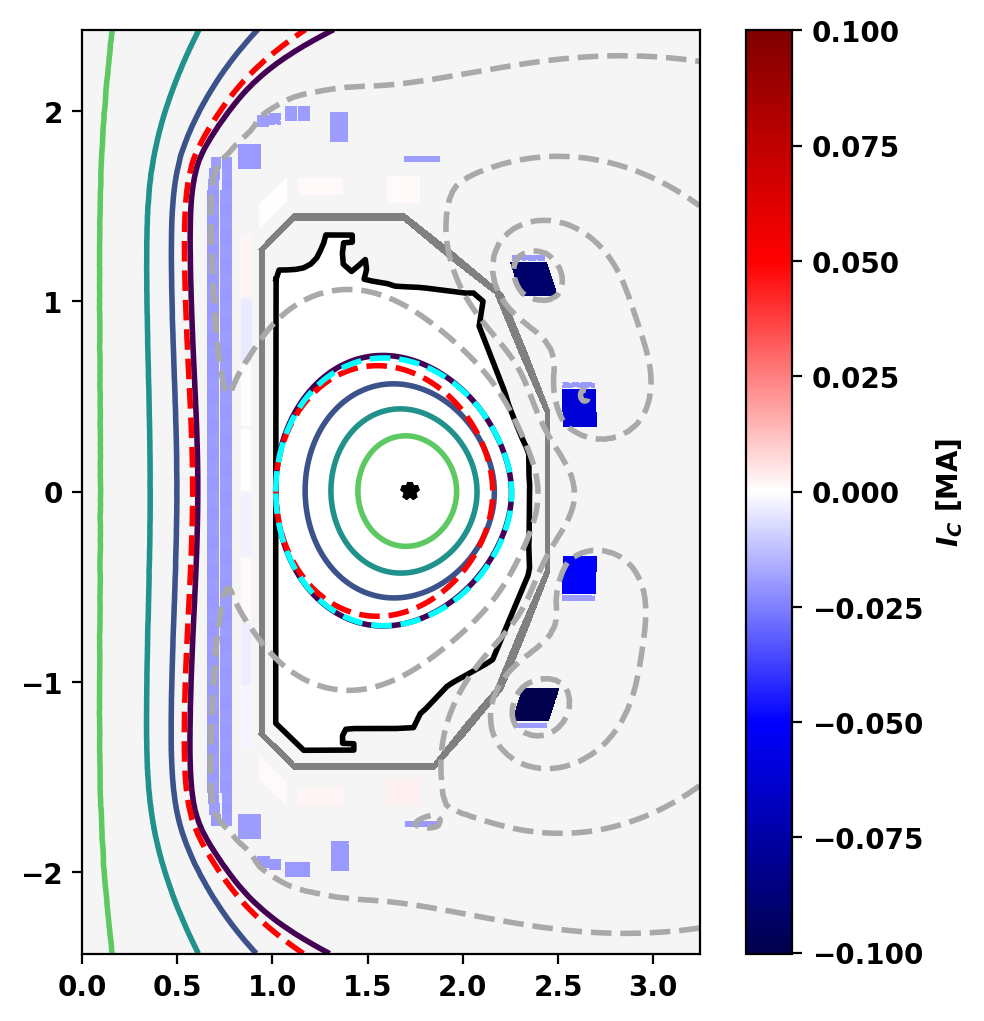

In [29]:
# Plot Psi
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_psi(fig,ax,psi_eq,plasma_levels=[1.0,],plasma_color='red',vacuum_nlevels=0,plasma_linestyles='dashed')

LCFS_eqdsk = eqdsk['rzout']
ax.plot(LCFS_eqdsk[:,0], LCFS_eqdsk[:,1], color='cyan', linestyle='--')

plt.show()

## Plot Current Density

Starting CG solver
     0  0.000000E+00  0.000000E+00  2.710695E-01
     1 -7.705282E+01  1.193737E+03  1.359815E-01  1.139124E-04
     2 -9.253082E+01  9.938387E+02  5.657182E-02  5.692254E-05
     3 -9.477556E+01  1.057576E+03  2.096996E-02  1.982832E-05
     4 -9.504264E+01  1.057565E+03  8.548779E-03  8.083456E-06
     5 -9.508755E+01  1.058585E+03  3.182971E-03  3.006818E-06
     6 -9.509291E+01  1.055072E+03  1.113514E-03  1.055392E-06
     7 -9.509365E+01  1.054899E+03  4.431784E-04  4.201145E-07
     8 -9.509376E+01  1.054725E+03  1.847712E-04  1.751843E-07
     9 -9.509378E+01  1.054685E+03  7.409272E-05  7.025104E-08
    10 -9.509379E+01  1.054724E+03  2.803007E-05  2.657573E-08
    20 -9.509379E+01  1.054748E+03  1.819635E-09  1.725185E-12


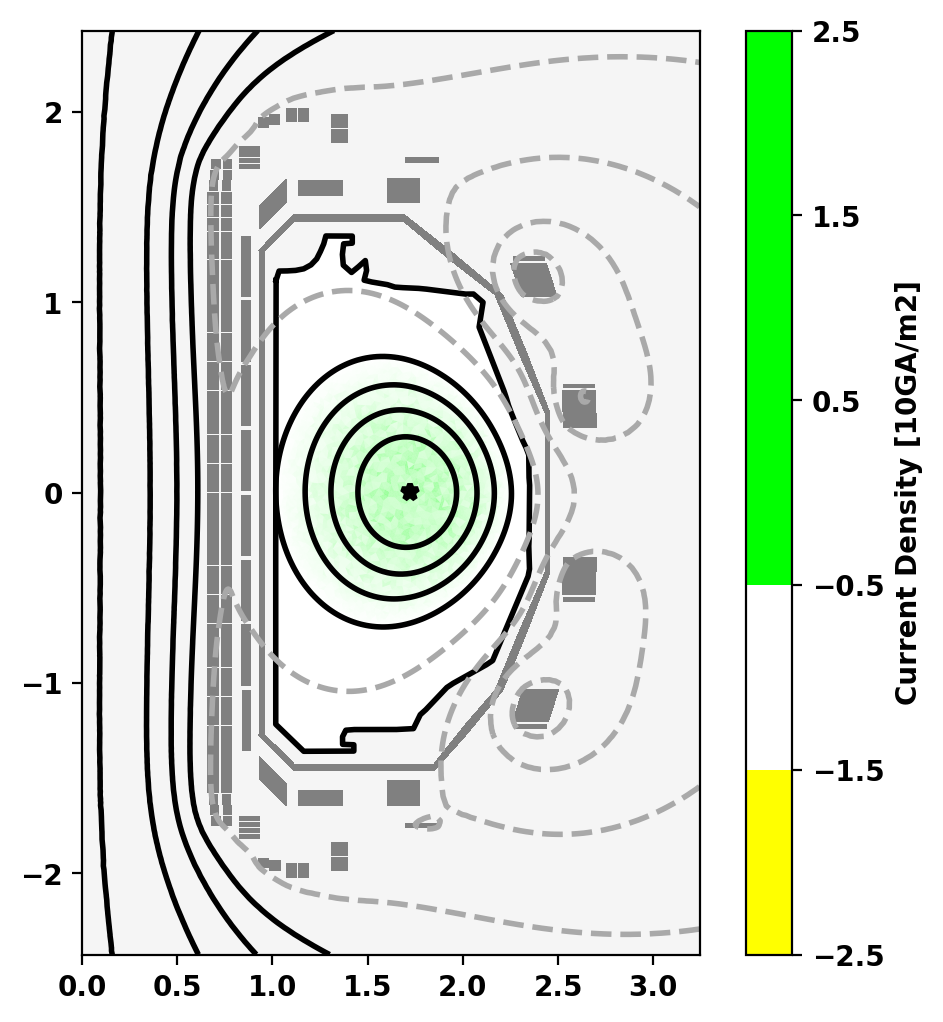

In [32]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(1,1)
cmap = ListedColormap(['black'])

mygs.plot_machine(fig,ax,coil_clabel=None)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5, plasma_colormap=cmap)
mygs.plot_current_density(fig, ax)

# Show the plot
plt.show()

## Plot Currents

In [ ]:
plot_currents()

In [ ]:
plot_mirnov()

In [ ]:
plot_flux()

## Get Strike Points

In [ ]:
strike_pts = mygs.get_strike_points()
print(strike_pts)

In [ ]:
# Plot Psi
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_psi(fig,ax,psi_eq,plasma_levels=[1.0,],plasma_color='red',vacuum_nlevels=0,plasma_linestyles='dashed')

strike_pts_r = [sp[0] for sp in strike_pts]
strike_pts_z = [sp[1] for sp in strike_pts]
ax.scatter(strike_pts_r, strike_pts_z, color='limegreen', zorder=10)

plt.show()